# notebook to develop open field analysis scripts.

In [638]:
import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats, spatial, fftpack
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import TreeMazeFunctions as TMF
import spike_functions as SF
import analyses_table as AT
import plot_functions as PF
import OpenFieldFunctions as OF
import spatial_tuning as ST
from importlib import reload  # Python 3.4+ only.
from pre_process_neuralynx import get_position
from filters_ag import *

### OF definitions

In [296]:
def ScaleRotateSmoothTrackDat(x,y,ha):
    # rotation angle for the maze (for original pixel space)
    rot_ang=np.pi/2+0.09

    # parameters for translation and scaling
    x_translate = -243
    y_translate = 610

    y_pix2mm = 1480/444
    x_pix2mm = 1300/344

    # speed thr
    spd_thr = 50 # mm/frame -> mm/frame*60frames/s*1cm/10mm = 50*6 cm/s

    ######## Operations ########
    # rotate
    x2,y2= RotateXY(x,y,rot_ang)

    # re-scale
    x2 = -(x2+x_translate)*x_pix2mm
    #x2[x2<0]=x2[x2<0]*1.1 # left warping
    y2 = (y2+y_translate)*y_pix2mm

    # compute velocity to create speed threshold
    dx = np.append(0,np.diff(x2))
    dy = np.append(0,np.diff(y2))
    dr = np.sqrt(dx**2+dy**2)
    mask_r = np.abs(dr)>spd_thr

    #mask creating out of bound zones
    mask_y = np.logical_or(y2<yLims[0],y2>yLims[1])
    mask_x = np.logical_or(x2<xLims[0],x2>xLims[1])
    mask = np.logical_or(mask_x,mask_y)
    mask = np.logical_or(mask,mask_r)

    x2[mask]=np.nan
    y2[mask]=np.nan
    ha2 = np.array(ha)
    ha2[mask]=np.nan
    
    # double round of median filters to deal with NaNs
    x3 = medFiltFilt(x2,med_filt_window)
    y3 = medFiltFilt(y2,med_filt_window)
    ha3 = medFiltFilt(ha2,med_ang_filt_window)
    ha3 = medFiltFilt(ha2,med_ang_filt_window)

    # if there are still NaNs assign id to previous value
    badIds = np.where(np.logical_or(np.isnan(x3), np.isnan(y3)))[0]
    for ii in badIds:
        x3[ii] = getLastNotNanVal(x3,ii)
        y3[ii] = getLastNotNanVal(y3,ii)
        ha3[ii] = getLastNotNanVal(ha3,ii)
        
    ha3 = ha3-180 # rotate angle (-180 to 180)
    # filter / spatial smoothing
    x3 = signal.filtfilt(filtCoeff,1,x3)
    y3 = signal.filtfilt(filtCoeff,1,y3)

    return x3,y3,ha3

def RotateXY(x,y,angle):
    x2 = x*np.cos(angle)+y*np.sin(angle)
    y2 = -x*np.sin(angle)+y*np.cos(angle)
    return x2,y2

def getLastNotNanVal(x,i):
    if i==0:
        return 0
    elif np.isnan(x[i]):
        return getLastNotNanVal(x,i-1)
    else:
        return x[i]


def resultant_vector_length(alpha, w=None, d=None, axis=None,
                            axial_correction=1, ci=None, bootstrap_iter=None):
    # source: https://github.com/circstat/pycircstat/blob/master/pycircstat/descriptive.py
    """
    Computes mean resultant vector length for circular data.
    This statistic is sometimes also called vector strength.
    :param alpha: sample of angles in radians
    :param w: number of incidences in case of binned angle data
    :param ci: ci-confidence limits are computed via bootstrapping,
               default None.
    :param d: spacing of bin centers for binned data, if supplied
              correction factor is used to correct for bias in
              estimation of r, in radians (!)
    :param axis: compute along this dimension, default is None
                 (across all dimensions)
    :param axial_correction: axial correction (2,3,4,...), default is 1
    :param bootstrap_iter: number of bootstrap iterations
                          (number of samples if None)
    :return: mean resultant length
    References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_
    """
    if axis is None:
        axis = 0
        alpha = alpha.ravel()
        if w is not None:
            w = w.ravel()

    cmean = _complex_mean(alpha, w=w, axis=axis,
                          axial_correction=axial_correction)

    # obtain resultant vector length
    r = np.abs(cmean)
    # obtain mean
    mean = np.angle(cmean)

    # for data with known spacing, apply correction factor to correct for bias
    # in the estimation of r (see Zar, p. 601, equ. 26.16)
    if d is not None:
        if axial_correction > 1:
            warnings.warn("Axial correction ignored for bias correction.")
        r *= d / 2 / np.sin(d / 2)
    # obtain variance
    variance = 1 - r
    std = np.sqrt(-2 * np.log(r))
    return r,mean,variance,std

def rayleigh(alpha, w=None, d=None, axis=None):
    """
    Computes Rayleigh test for non-uniformity of circular data.
    H0: the population is uniformly distributed around the circle
    HA: the populatoin is not distributed uniformly around the circle
    Assumption: the distribution has maximally one mode and the data is
    sampled from a von Mises distribution!
    :param alpha: sample of angles in radian
    :param w:       number of incidences in case of binned angle data
    :param d:     spacing of bin centers for binned data, if supplied
                  correction factor is used to correct for bias in
                  estimation of r
    :param axis:  compute along this dimension, default is None
                  if axis=None, array is raveled
    :return pval: two-tailed p-value
    :return z:    value of the z-statistic
    References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_
    """
    # if axis is None:
    # axis = 0
    #     alpha = alpha.ravel()

    if w is None:
        w = np.ones_like(alpha)

    assert w.shape == alpha.shape, "Dimensions of alpha and w must match"

    r,mean,variance,std = resultant_vector_length(alpha, w=w, d=d, axis=axis)
    n = np.sum(w, axis=axis)

    # compute Rayleigh's R (equ. 27.1)
    R = n * r

    # compute Rayleigh's z (equ. 27.2)
    z = R ** 2 / n

    # compute p value using approxation in Zar, p. 617
    pval = np.exp(np.sqrt(1 + 4 * n + 4 * (n ** 2 - R ** 2)) - (1 + 2 * n))
    return pval, z

def _complex_mean(alpha, w=None, axis=None, axial_correction=1):
    # REQUIRED for mean vector length calculation
    if w is None:
        w = np.ones_like(alpha)
    alpha = np.asarray(alpha)

    assert w.shape == alpha.shape, "Dimensions of data " + str(alpha.shape) \
                                   + " and w " + \
        str(w.shape) + " do not match!"


    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            cmean = ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) / np.sum(w, axis=axis))
        except Warning as e:
            print('Could not compute complex mean for MVL calculation', e)
            cmean = np.nan
    return cmean


In [6]:
oakPaths = AT.getOakPaths()

In [7]:
sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})

### Load data 

In [8]:
an = 'Li'
task = 'OF'
fn = oakPaths['Root'] / (an+'_SessionPaths.pkl')
with fn.open(mode="rb") as f:
    sePaths = pkl.load(f)

CT_Path =  oakPaths['Clustered'] / an / (an+'_ClusteringSummary.json')
with CT_Path.open() as f:
    CT = json.load(f)

seTTInfo = pd.read_csv(str(oakPaths['Clustered'] / (an + '_SeTTInfo.csv' )),dtype={'Dates':str})
seTTInfo=seTTInfo.set_index('Dates')

unitIDs =pd.read_csv(str(oakPaths['Clustered'] / 'UnitTable.csv' ),index_col=0)


In [9]:
seTTInfo[seTTInfo['OF']>0].index

Index(['052818', '052918', '053018', '060118', '060518', '060718', '060818',
       '061118', '061218', '061318', '061418', '061518', '061818', '062018',
       '062518', '062618', '062718', '062818', '062918', '070218', '070618',
       '071018', '080118', '080218'],
      dtype='object', name='Dates')

### select a session for development

In [1230]:
date = '062718'
se = '{}_{}_{}'.format(an,task,date)
OFBehavParams = {'timeStep':0.02,'mm2bin':30, 'spThr':5, 'ang2bin':np.deg2rad(10), 'secThr':0.1,'xLims':[-650,650],'yLims':[-100,1500],'sm_sigma':1.5,'sm_w':5}

In [432]:
for k,v in OFBehavParams.items():
    eval('{} = {}'.format(k,v))
    #print('{} = {}'.format(k,v))

timeStep = 0.02
mm2bin = 30
spThr = 5
ang2bin = 0.17453292519943295
secThr = 0.1
xLims = [-650, 650]
yLims = [-100, 1500]
sm_sigma = 1.5
sm_w = 5


In [473]:
fn = sePaths[se]['Raw'] / 'VT1.nvt'
t,x,y,ha = get_position(fn)
step =  OFBehavParams['timeStep']

In [434]:
sePaths[se]

{'session': 'Li_OF_062718',
 'animal': 'Li',
 'task': 'OF',
 'date': '062718',
 'step': 0.02,
 'SR': 32000,
 'Clusters': PosixPath('/mnt/o/giocomo/alexg/Clustered/Li/Li_OF_062718_KSClusters'),
 'Raw': PosixPath('/mnt/o/giocomo/alexg/RawData/InVivo/Li/Li_OF_062718'),
 'PreProcessed': PosixPath('/mnt/o/giocomo/alexg/PreProcessed/Li/Li_OF_062718_Results'),
 'Analyses': PosixPath('/mnt/o/giocomo/alexg/Analyses/Li/Li_OF_062718_Analyses'),
 'ClusterTable': PosixPath('/mnt/o/giocomo/alexg/Clustered/Li/Li_ClusteringSummary.json'),
 'BehavTrackDat': PosixPath('/mnt/o/giocomo/alexg/Analyses/Li/Li_OF_062718_Analyses/BehTrackVariables_20ms.h5'),
 'Cell_Spikes': PosixPath('/mnt/o/giocomo/alexg/Analyses/Li/Li_OF_062718_Analyses/Cell_Spikes.json'),
 'Cell_WaveForms': PosixPath('/mnt/o/giocomo/alexg/Analyses/Li/Li_OF_062718_Analyses/Cell_WaveForms.pkl'),
 'Cell_WaveFormInfo': PosixPath('/mnt/o/giocomo/alexg/Analyses/Li/Li_OF_062718_Analyses/Cell_WaveFormInfo.pkl'),
 'Cell_Bin_Spikes': PosixPath('/mnt/

In [364]:
yLims = OFBehavParams['yLims']
xLims = OFBehavParams['xLims']

### rescaled & proccesed xy data

In [479]:

# filtering params
med_filt_window = 12 #
smooth_filt_window = 12 # in samples 12/60 = 200ms
med_ang_filt_window = 6
filtCoeff = signal.firwin(smooth_filt_window, cutoff = 0.2, window = "hanning")


x3,y3,ha2 = OF.ScaleRotateSmoothTrackDat(x,y,ha)

sp,hd = TMF.getVelocity(x2,y2,1/60)
sp = sp/10 # conver to cm/s
hd = np.rad2deg(hd) # conver to deg

In [507]:
OF = reload(OF)
x6,y6,ha3=OF.ScaleRotateSmoothTrackDat(x,y,ha)

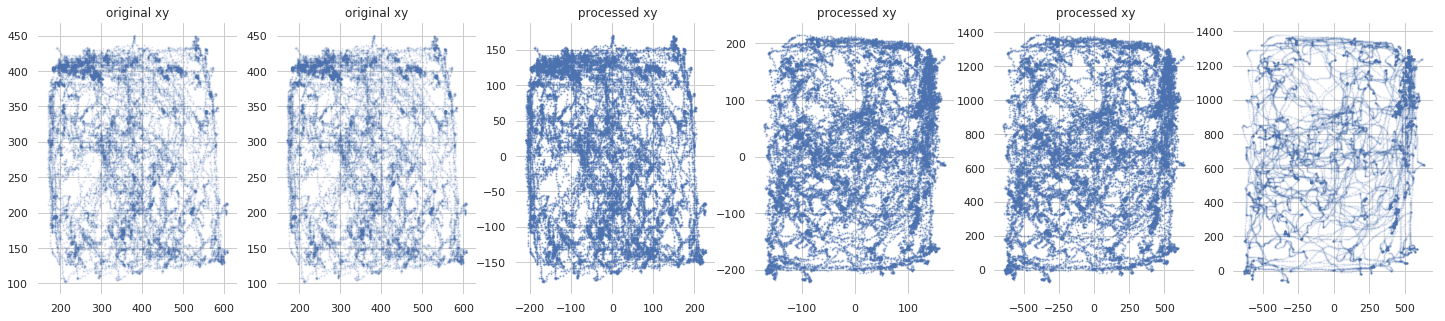

In [508]:
f,ax = plt.subplots(1,6,figsize=(25,5))

mask_x = np.logical_or(x<100,x>650)
mask_y = np.logical_or(y<100,y>600)
mask = np.logical_or(mask_x,mask_y)

x2 = np.array(x)
y2 = np.array(y)

x2[mask] = np.nan
y2[mask] = np.nan

x3=x2-380
y3=y2-280

x4,y4=ST.RotateXY(x3,y3,np.pi/2+0.08)
ax[0].scatter(x,y,1,alpha=0.1)
ax[0].set_title('original xy')

ax[1].scatter(x2,y2,1,alpha=0.1)
ax[1].set_title('original xy')

ax[2].scatter(x3,y3,1,alpha=0.3)
ax[2].set_title(' processed xy')

ax[3].scatter(x4,y4,1,alpha=0.3)
ax[3].set_title(' processed xy')

x5 = x4*1300/344
y5 = (y4+200)*1480/444

ax[4].scatter(x5,y5,1,alpha=0.3)
ax[4].set_title(' processed xy')


ax[5].scatter(x6,y6,1,alpha=0.1)

In [504]:
np.nanmax(x4)-np.nanmin(x4)

341.77671731590857

Text(0.5, 1.0, 'in xy space ')

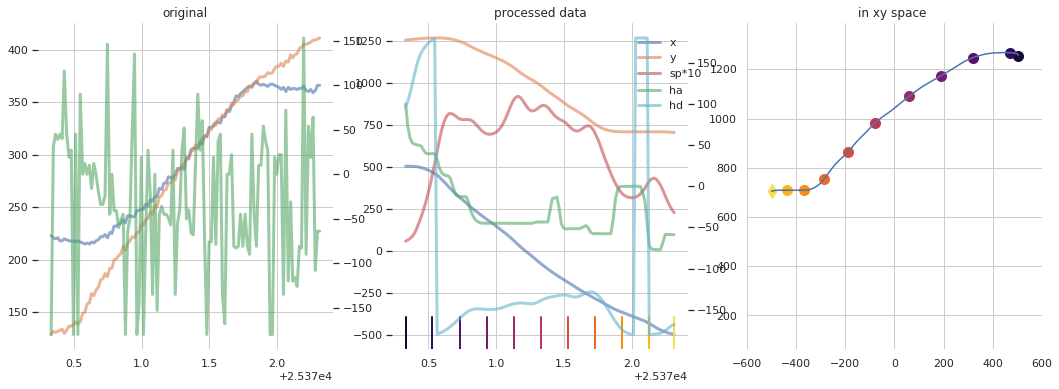

In [14]:
win = np.arange(120) + 14*1000 

cols = sns.color_palette('inferno',n_colors=11)
winvals = np.arange(0,len(win),len(win)/10,dtype=int)

f,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(t[win],x[win],linewidth=3,alpha=0.6)
ax[0].plot(t[win],y[win],linewidth=3,alpha=0.6)
axx = ax[0].twinx()
axx.plot(t[win],ha[win]-180,color='g',linewidth=3,alpha=0.6)
axx.grid(0)
ax[0].set_title('original')

ax[1].plot(t[win],x2[win],label='x',linewidth=3,alpha=0.6)
ax[1].plot(t[win],y2[win],label='y',linewidth=3,alpha=0.6)
ax[1].plot(t[win],sp[win]*10,label='sp*10',linewidth=3,alpha=0.6,color='r')
axx = ax[1].twinx()
axx.grid(0)
axx.plot(t[win],ha2[win],label='ha',linewidth=3,alpha=0.6,color='g')
axx.plot(t[win],hd[win],label='hd',linewidth=3,alpha=0.6,color='c')
ax[1].set_title( 'processed data')

ax[1].axvline(t[win][-1],color=cols[-1],ymax=0.1,linewidth=2)
ax[1].legend(loc=3,bbox_to_anchor =[0.8,0.8],frameon=False)
axx.legend(loc=3,bbox_to_anchor =[0.8,0.7],frameon=False)

ax[2].plot(x2[win],y2[win])
ax[2].scatter(x2[win][-1],y2[win][-1],100,marker='d',color=cols[-1])

cnt=0
for w in winvals:
    ax[1].axvline(t[win][w],color=cols[cnt],ymax=0.1,linewidth=2)
    ax[2].scatter(x2[win][w],y2[win][w],100,marker='o',color=cols[cnt])
    cnt+=1

ax[2].axis('equal')
ax[2].set_xlim([-600,600])
ax[2].set_ylim([-50, 1500])
ax[2].set_title( 'in xy space ')

# plt.plot(t[win],s3[win],label='s')
# plt.plot(t[win],a3[win],label='a')


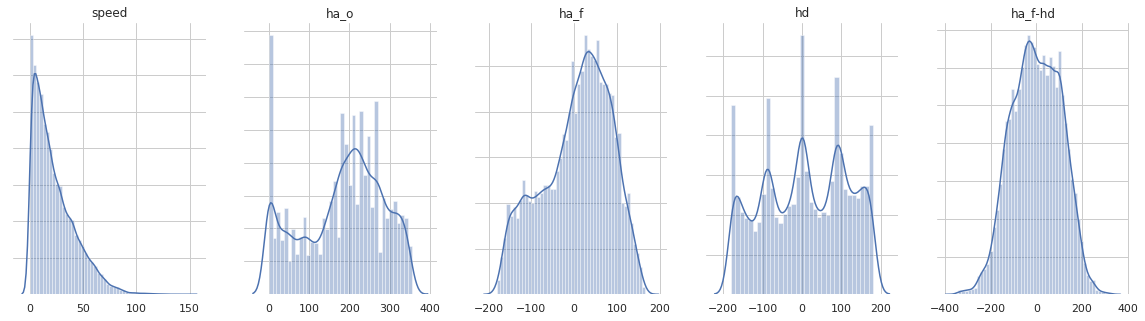

In [15]:
f,ax = plt.subplots(1,5,figsize=(20,5))
sns.distplot(sp,ax=ax[0])
sns.distplot(ha[sp>5],ax=ax[1])
sns.distplot(ha2[sp>5],ax=ax[2])
sns.distplot(hd[sp>5],ax=ax[3])
sns.distplot(ha2[sp>5]-hd[sp>5],ax=ax[4])

titles = ['speed','ha_o','ha_f','hd','ha_f-hd']
cnt=0
for a in ax:
    a.set_yticklabels([])
    a.set_title(titles[cnt])
    cnt+=1

#### current variables of interest: 

* x2 -> filtered x position (mm)
* y2 -> filtered y position (mm)
* hd -> head direction (in degrees; -180 to 180)
* ha2 -> filtered head angle (in degrees)
* sp -> speed [cm/s]
* t -> time [s]
* ts -> resampled time

### resample the data to 20ms (from 16.67ms)

In [16]:
ts, xs   = ReSampleDat(t,x2,step)
_, ys   = ReSampleDat(t,y2,step)
_, hds   = ReSampleDat(t,hd,step)
_, ha2s =  ReSampleDat(t,ha2,step)
_, sps =  ReSampleDat(t,sp,step)
ts = np.round(ts*1000)/1000 #round tp to ms resolution.


Text(0.5, 1.0, 'in xy space ')

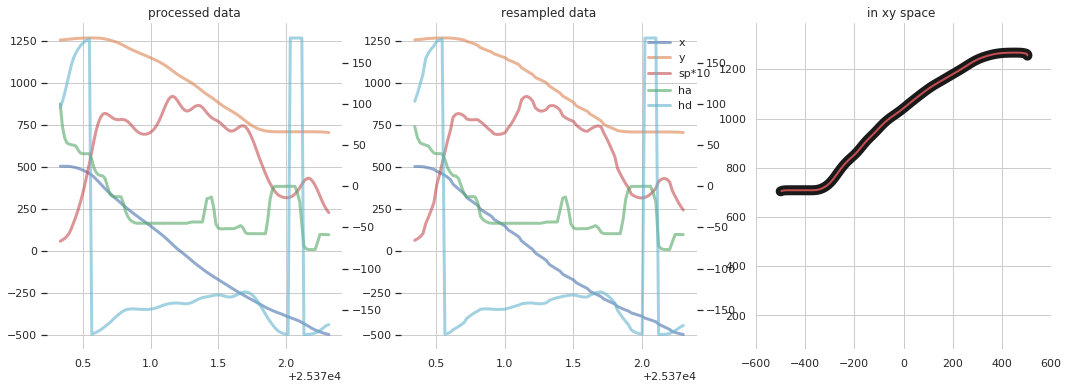

In [17]:
idx = np.logical_and(ts>t[win][0],ts<t[win][-1])
idx = np.where(idx)[0]
cols = sns.color_palette('inferno',n_colors=11)
winvals = np.arange(0,len(idx),len(idx)/10,dtype=int)

f,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(t[win],x2[win],label='x',linewidth=3,alpha=0.6)
ax[0].plot(t[win],y2[win],label='y',linewidth=3,alpha=0.6)
ax[0].plot(t[win],sp[win]*10,label='sp*10',linewidth=3,alpha=0.6,color='r')
axx = ax[0].twinx()
axx.grid(0)
axx.plot(t[win],ha2[win],label='ha',linewidth=3,alpha=0.6,color='g')
axx.plot(t[win],hd[win],label='hd',linewidth=3,alpha=0.6,color='c')
ax[0].set_title( 'processed data')


ax[1].plot(ts[idx],xs[idx],label='x',linewidth=3,alpha=0.6)
ax[1].plot(ts[idx],ys[idx],label='y',linewidth=3,alpha=0.6)
ax[1].plot(ts[idx],sps[idx]*10,label='sp*10',linewidth=3,alpha=0.6,color='r')
axx = ax[1].twinx()
axx.grid(0)
axx.plot(ts[idx],ha2s[idx],label='ha',linewidth=3,alpha=0.6,color='g')
axx.plot(ts[idx],hds[idx],label='hd',linewidth=3,alpha=0.6,color='c')
ax[1].set_title( 'resampled data')

ax[1].legend(loc=3,bbox_to_anchor =[0.8,0.8],frameon=False)
axx.legend(loc=3,bbox_to_anchor =[0.8,0.7],frameon=False)

ax[2].plot(x2[win],y2[win],color='k',linewidth=10)
ax[2].plot(xs[idx],ys[idx],color='r',linewidth=2)


#cnt=0
#for w in winvals:
#    ax[1].axvline(t[win][w],color=cols[cnt],ymax=0.1,linewidth=2)
#    ax[2].scatter(x2[win][w],y2[win][w],100,marker='o',color=cols[cnt])
#    cnt+=1

ax[2].axis('equal')
ax[2].set_xlim([-600,600])
ax[2].set_ylim([-50, 1500])
ax[2].set_title( 'in xy space ')


### Occupancy map

In [464]:
mm2bin = 30
Occ_Counts,xe,ye =ST.getPositionMat(ys,xs,yLims,xLims,spacing=mm2bin)

T = np.max(ts)-np.min(ts)
print('Total Time = ', T)
nBins = Occ_Counts.size
print('Total number of bins = ', nBins)
nOccBin = Occ_Counts.sum()
print('Total number of occupancy ticks = ', nOccBin)
bin2sec = T/nOccBin;
print('Bin to Time conversion factor [s] = ', bin2time)
Occ_Secs = Occ_Counts*bin2sec

Occ_SmSecs = ST.getSmoothMap(Occ_Secs,w,s)

Total Time =  645.380000000001
Total number of bins =  2279
Total number of occupancy ticks =  32270.0
Bin to Time conversion factor [s] =  0.019999380229315186


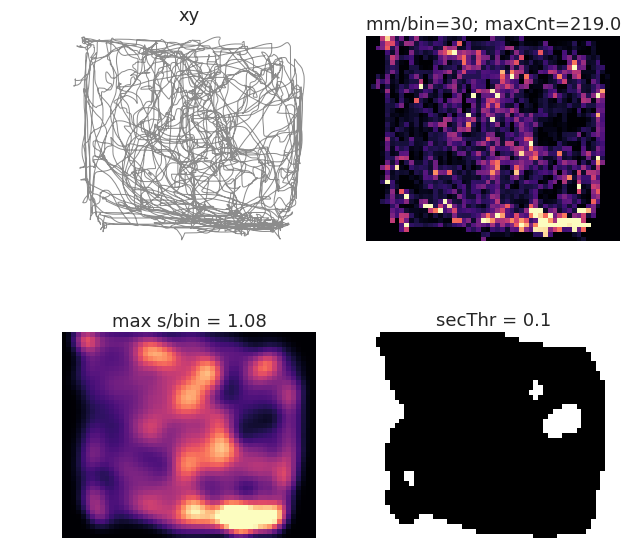

In [367]:
f,ax=plt.subplots(2,2,figsize=(10,10))

secThr = 0.1
ax=ax.flatten()

ax[0].plot(ys,xs,linewidth=1,color='k',alpha=0.5)   
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_axis_off()

ax[1]=sns.heatmap(Occ_Counts,xticklabels=[],yticklabels=[],cmap='magma',square=True,robust=True,cbar=False,ax=ax[1])
ax[1].invert_yaxis()

w=5
s=1.5
Occ_SmSecs = ST.getSmoothMap(Occ_Secs,w,s)
ax[2]=sns.heatmap(Occ_SmSecs,xticklabels=[],cmap='magma',yticklabels=[],square=True,robust=True,cbar=False,ax=ax[2])
ax[2].invert_yaxis()


ax[3]=sns.heatmap(Occ_SmSecs>secThr,cmap='Greys',xticklabels=[],yticklabels=[],square=True,cbar=False,ax=ax[3])
ax[3].invert_yaxis()

titles = ['xy','mm/bin={}; maxCnt={}'.format(mm2bin,Occ_Counts.max()), 'max s/bin = {0:0.2f}'.format(Occ_SmSecs.max()), 'secThr = {}'.format(secThr) ]
cnt=0
for a in ax:
    a.set_title(titles[cnt])
    cnt+=1

### HD computations

In [469]:
def getColBar(ax,values,cmap = 'magma'):
    pos = ax.get_position()
    cax = plt.axes([pos.x0+pos.width*0.85,pos.y0,0.05*pos.width,0.2*pos.height])

    cMap=mpl.colors.ListedColormap(sns.color_palette(cmap,50))
    vmax = values.max()
    vmin = values.min()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cMap)

    mapper.set_array([])
    cbar = plt.colorbar(mapper,ticks=[vmin,vmax],cax=cax)
    cax.yaxis.set_tick_params(right=False)
    return cax

def angle_stats(th,step=10,th_units='deg'):
    if th_units=='deg':
        th = np.deg2rad(th)
        step = np.deg2rad(step)

    counts,bins=np.histogram(th,np.arange(-np.pi,np.pi+0.01,step))
    binCenters=bins[:-1]+step
    
    z = np.mean(counts*np.exp(1j*binCenters))
    ang = np.angle(z)
    r = np.abs(z)
    p,t=rayleigh(th)
    
    stats = {'r':r,'ang':ang,'R':t,'pval':p, 'counts':counts, 'bins': bins,'binCenters': binCenters}
    
    return stats

def allOFBehavPlots(OFBehavDat,OFBehavParams):
    
    secThr = OFBehavParams['secThr']
    sp = OFBehavDat['sp']
    se = OFBehavDat['se']

    f = plt.figure(figsize=(16,18))

    gsTop = mpl.gridspec.GridSpec(2,3)
    axTop = np.full((2,3),type(gsTop[0,0])) 
    for i in np.arange(2):
        for j in np.arange(3):
            axTop[i,j] = f.add_subplot(gsTop[i,j])
    gsTop.tight_layout(f,rect=[0,0.3,1,0.68])

    # xy traces
    axTop[0,0].plot(OFBehavDat['x'],OFBehavDat['y'],linewidth=1,color='k',alpha=0.5)   
    axTop[0,0].set_aspect('equal', adjustable='box')
    #axTop[0,0].set_axis_off()

    axTop[0,1]=sns.heatmap(OFBehavDat['Occ_Counts'],xticklabels=[],yticklabels=[],cmap='magma',square=True,robust=True,cbar=False,ax=axTop[0,1])
    axTop[0,1].invert_yaxis()

    Occ_SmSecs = ST.getSmoothMap(OFBehavDat['Occ_Secs'],w,s)
    axTop[0,2]=sns.heatmap(OFBehavDat['Occ_SmSecs'],xticklabels=[],cmap='magma',yticklabels=[],square=True,robust=True,cbar=False,ax=axTop[0,2])
    axTop[0,2].invert_yaxis()

    axTop[1,0]= sns.heatmap(OFBehavDat['Occ_Counts']>secThr,cmap='Greys',xticklabels=[],yticklabels=[],square=True,cbar=False,ax=axTop[1,0])
    axTop[1,0].invert_yaxis()

    axTop[1,1]= sns.distplot(sp,ax=axTop[1,1])
    axTop[1,1].set_yticklabels([])


    axTop[1,2] = sns.distplot(OFBehavDat['HAo'],ax=axTop[1,2])
    axTop[1,2].set_yticklabels([])

    titles = ['xy','mm/bin={}; maxCnt={}'.format(OFBehavParams['mm2bin'],OFBehavDat['Occ_Counts'].max()), 'max s/bin = {0:0.2f}'.format(OFBehavDat['Occ_Counts'].max()), 
              'secThr = {}'.format(secThr), 'Speed [cm/s]', 'HA orig [deg]' ]
    cnt=0
    for a in axTop.flatten():
        a.set_title(titles[cnt])
        cnt+=1


    gsBot = mpl.gridspec.GridSpec(1,4)
    axBot = np.full(4,type(gsBot))
    for i in np.arange(4):
        axBot[i] = f.add_subplot(gsBot[i],projection='polar')
    gsBot.tight_layout(f,rect=[0,0,1,0.3])


    for i in [0,1]:
        if i==0:
            th = OFBehavDat['HA'][sp>OFBehavParams['spThr']]
            txt = 'HA'
        else:
            th = OFBehavDat['HD'][sp>OFBehavParams['spThr']]
            txt = 'HD'

        stats = angle_stats(th)
        counts = stats['counts']
        bins = stats['bins']
        ang = stats['ang']
        r = stats['r']
        R = stats['R']
        pval = stats['pval']

        axBot[0+i*2].plot(bins,np.append(counts,counts[0]),linewidth=4)
        axBot[0+i*2].plot([0,ang],[0,r],color='k',linewidth=4)
        axBot[0+i*2].scatter(ang,r,s=50,color='red')
        #axBot[0+i*2].set_title('r={0:0.1f},th={1:0.1f},R={2:0.2f},p={3:0.2f}'.format(r,np.rad2deg(ang),R,pval) )
        axBot[0+i*2].set_xticklabels([0,'','','','180'])
        axBot[0+i*2].set_yticks([])
        axBot[0+i*2].text(0,-0.1,'r={0:0.1f},th={1:0.1f},R={2:0.2f},p={3:0.2f}'.format(r,np.rad2deg(ang),R,pval), transform=axBot[0+i*2].transAxes)

        counts2 = counts* OFBehavParams['timeStep']
        colors = plt.cm.magma(counts2/counts2.max())
        axBot[1+i*2].bar(bins[:-1],counts2,width=OFBehavParams['ang2bin'],color=colors,bottom=counts2.min())
        axBot[1+i*2].set_axis_off()
        cax=getColBar(axBot[1+i*2],counts2)
        cax.yaxis.set_label('sec')

    ax = plt.axes([0,0.26,1,0.1])
    ax.text(0,0,'HD', {'fontsize':20})
    ax.plot([0,0.45],[-0.1,-0.1],color='k',linewidth=4)
    ax.text(0.5,0,'HA',{'fontsize':20})
    ax.plot([0.5,0.95],[-0.1,-0.1],color='k',linewidth=4)
    ax.set_axis_off()
    ax.set_xlim([0,1])
    ax.set_ylim([-.1,1])

    ax = plt.axes([0,0.7,1,0.05])
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.text(0,0,se,{'fontsize':30},transform=ax.transAxes)

    ax.set_axis_off() 
    return f

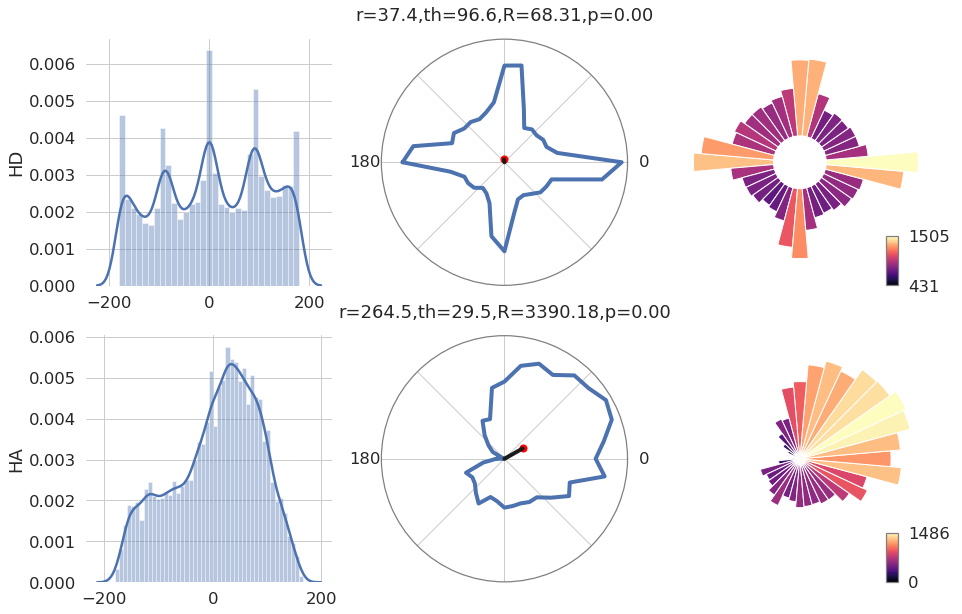

In [293]:
spThr = 5
step =10
bins = np.arange(-np.pi,np.pi+0.01,np.deg2rad(10))

fig = plt.figure(figsize=(15,10))
cnt=1
for i in [1,2]:
    if i==1:
        th = hds[sps>spThr]
        txt = 'HD'
    else:
        th = ha2s[sps>spThr]
        txt = 'HA'
    
    stats = angle_stats(th,step)
    r = stats['r']
    ang = stats['ang']
    counts = stats['counts']
    R = stats['R']
    pval = stats['pval']
    
    
    ax1 = fig.add_subplot(2,3,cnt)
    ax1 = sns.distplot(th)
    ax1.set_ylabel(txt)
    cnt+=1

    ax2 = fig.add_subplot(2,3,cnt,projection='polar')
    ax2.plot(bins,np.append(counts,counts[0]),linewidth=4)
    
    ax2.plot([0,ang],[0,r],color='k',linewidth=4)
    ax2.scatter(ang,r,s=50,color='red')
    ax2.set_title('r={0:0.1f},th={1:0.1f},R={2:0.2f},p={3:0.2f}'.format(r,np.rad2deg(ang),R,pval) )
    ax2.set_xticklabels([0,'','','',180])
    
    #ax2.set_axis_off()
    ax2.set_yticks([])
    cnt+=1

    ax3 = fig.add_subplot(2,3,cnt,projection='polar')
    w = np.deg2rad(step)
    colors = plt.cm.magma(counts/counts.max())
    ax3.bar(bins[:-1],counts,width=w,color=colors,bottom=counts.min())
    #ax3.set_yticks([])
    ax3.set_axis_off()
    _=getColBar(ax3,counts)
    cnt+=1

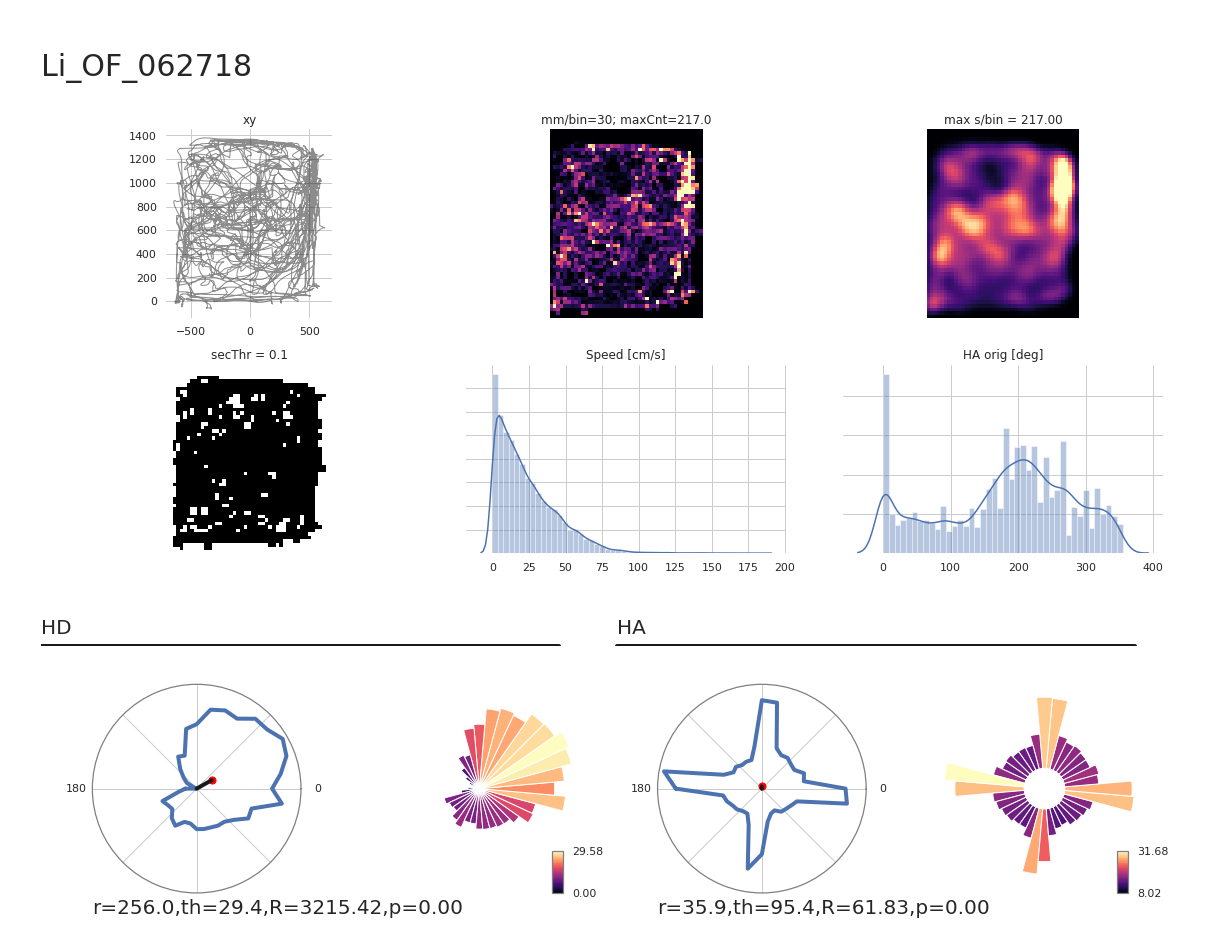

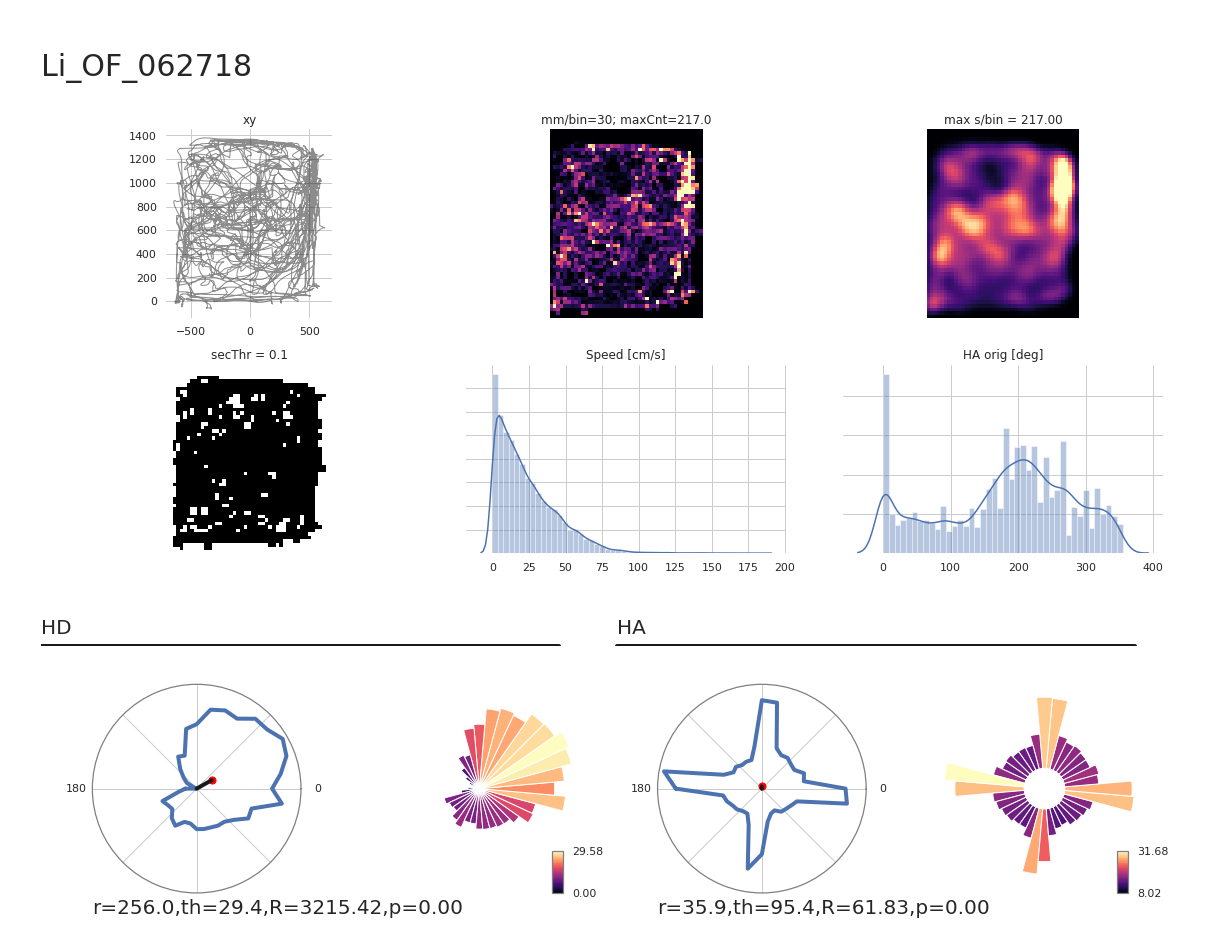

In [511]:
# OFBehavDat = {'se':se,'x':xs,'y':ys,'sp':sps,'Occ_Counts':Occ_Counts,'Occ_Secs':Occ_Secs, 'Occ_SmSecs': Occ_SmSecs ,
#               'HA':ha2s,'HD':hds,'HAo':ha,'HA_Stats':angle_stats(ha2s[sps>spThr]),'HD_Stats':angle_stats(hds[sps>spThr]) }
allOFBehavPlots(OFBehavDat,OFBehavParams)

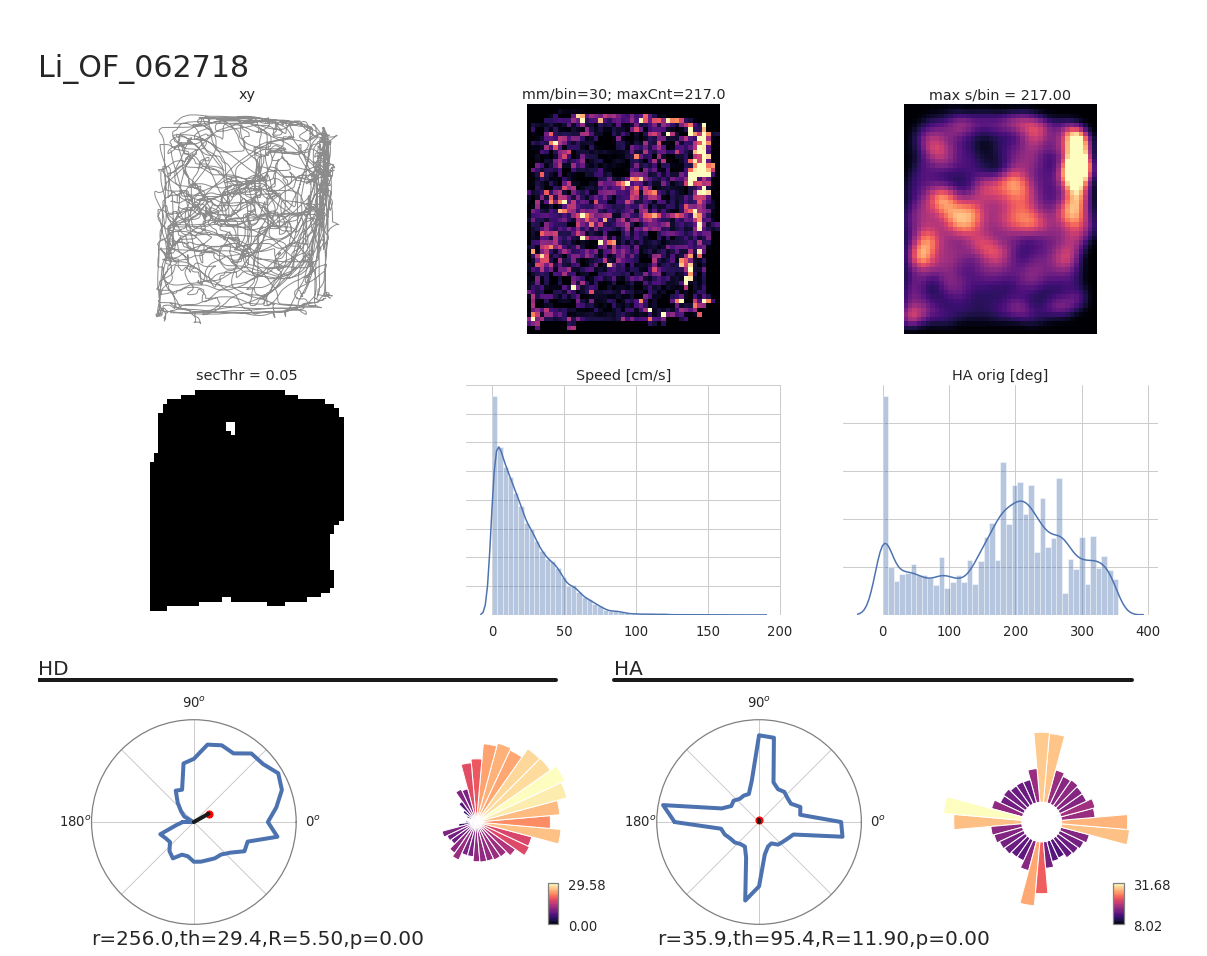

In [1231]:
OF = reload(OF)
ST = reload(ST)
OFBehavDat = OF.getOFBehavior(sePaths[se])
f=OF.allOFBehavPlots(OFBehavDat)

# Spike Functions

## get spikes

In [1232]:
cell_bin_spikes, mua_bin_spikes, ids= SF.getSessionBinSpikes(sePaths[se],resamp_t=OFBehavDat['t'])
cell_FR, mua_FR = SF.getSessionFR(sePaths[se], cell_bin_spikes=cell_bin_spikes,mua_bin_spikes=mua_bin_spikes)


Loading Binned Spikes...
Binned Spike Files Loaded.
Loading FRs ...
FR Loaded.


In [1092]:
x = OFBehavDat['x']
y = OFBehavDat['y']
t = OFBehavDat['t']

HA = OFBehavDat['HA']
HA_Stats = OFBehavDat['HA_Stats']

HD = OFBehavDat['HD']
HD_Stats = OFBehavDat['HD_Stats']

sp = OFBehavDat['sp']
sp_mask = sp>OFBehavParams['spThr']


### spike OF function definitions

In [1376]:
OF = reload(OF)
ST = reload(ST)
def getSpikesPos(x,y, spikes, xlimits, ylimits, spacing=30):
    xedges=np.arange(xlimits[0],xlimits[1]+1,spacing)
    yedges=np.arange(ylimits[0],ylimits[1]+1,spacing)
    position_2d,_,_ = np.histogram2d(x,y, bins=[xedges, yedges],weights=spikes)
    return position_2d, xedges, yedges

def spatial_information(occTime, fr_map):
    occupancy_prob = occTime/occTime.sum()
    meanFR = np.nanmean(fr_map)
    InfoMat = fr_map*occupancy_prob*np.log2(fr_map/meanFR)
    return 1/meanFR*np.nansum(InfoMat)

def acc2d(X):
    '''
    Normalized 2D autocorrelation using the FFT approach.
    '''
    n,m = X.shape
    H = np.fft.fft2(X,[2*n-1,2*m-1]) # 2d FFT w zero padding
    H /= np.sqrt( (H**2).sum() ) # variance normalization
    acc = np.fft.fftshift(np.fft.ifft2(H*np.conjugate(H))) # HxH* and shifts fft quadrants to the center
    acc = np.real(acc) # takes care of numerical errors 

    return acc
    
def getSI_ShuffleScore(x,y,spikes,OccTime,si_score,sampThr = 250, nPerm = 200, xLims = [-650,650], yLims = [-100,1450]):
    n = len(x)
    SampThr = [250, n-250]
   
    rollVals = np.random.randint(sampThr,n-sampThr,nPerm)
    
    si_r = np.zeros(nPerm)
    cnt=0
    for r in rollVals:
        spikes_r = np.roll(spikes,r)
        PosSpikes,_,_ = getSpikesPos(y,x,spikes_r,yLims,xLims)
        smFR_r = getSmFR(PosSpikes,OccTime)
        si_r[cnt] = spatial_information(OccTime,smFR_r)
        cnt+=1
        
    p = getPerm_Pval(si_r,si_score)
    z = getPerm_Z(si_r,si_score)
    return p,z
        
    
def getSmFR(PosSpikes,OccTime):
    mask = OccTime>0
    smPosSpikes = ST.smooth_hist2d(PosSpikes)
    
    # get firing rate 
    PosFR = np.full_like(smPosSpikes,0)
    PosFR[mask] = smPosSpikes[mask]/OccTime[mask]
    smPosFR = ST.smooth_hist2d(PosFR)
    
    return smPosFR

def getPosFR(spikes, OFBehavDat, secThr =0.05, spThr = 5, xLims = [-650,650], yLims = [-100,1450]):
    
    # get behavioral variables
    Occ_SmSecs = OFBehavDat['Occ_SmSecs']
    x =  OFBehavDat['x']
    y =  OFBehavDat['y']
    sp = OFBehavDat['sp']
    
    # get speed and occupancy masks
    sp_mask = sp>spThr
    Occ_mask = Occ_SmSecs>secThr

    OccTime = np.full_like(Occ_SmSecs,0)
    OccTime[Occ_mask] = Occ_SmSecs[Occ_mask]

    # compute position spikes
    PosSpikes,_,_ = getSpikesPos(y[sp_mask],x[sp_mask], spikes[sp_mask], yLims,xLims)
    smPosFR =  getSmFR(PosSpikes,OccTime,)
    
    # get autocorrelation
    autoCorr = acc2d(smPosFR)
    
    # get spatial information
    si = spatial_information(OccTime,smPosFR)
    si_p, si_z = getSI_ShuffleScore(x[sp_mask],y[sp_mask],spikes[sp_mask],OccTime,si)
    
    PosFRStats = {'PosSpikes':PosSpikes, 'smPosFR':smPosFR, 'OccTime': OccTime, 'AutoCorr': autoCorr, 'SI': [si,si_z,si_p]}

    return PosFRStats

def getPerm_Pval(nullDist,score):
    nP = len(nullDist)
    p = 1-np.sum(score>nullDist)/nP
    if p==0:
        p = 1/(nP+1)
    if p==1:
        p = 1-1/(nP+1)
    return p

def getPerm_Z(nullDist,score):
    tol = 0.001
    m = np.nanmean(nullDist)
    s = np.nanstd(nullDist + np.random.randn(len(nullDist))*tol)

    return (score-m)/s

def plotXYSpikes(x,y,spikes,smSpPos,smFrPos,autoCorr):
    f,ax = plt.subplots(2,2,figsize=(12,12))

    ax=ax.flatten()
    ax[0].plot(x,y,linewidth=1,color='k',alpha=0.5)
    ax[0].scatter(x,y,s=spikes*3,color='r',alpha=0.7)
    ax[0].set_aspect('equal',adjustable='box')
    ax[0].set_axis_off()
    ax[0].set_title('Traces + Spikes')

    vmax=smSpPos.max()
    ax[1] = sns.heatmap(smSpPos,xticklabels=[],yticklabels=[],cmap='viridis',robust=True,square=True,cbar=False,ax=ax[1])
    ax[1].invert_yaxis()
    # cax=getColBar(ax[1],smSpPos,cmap='viridis')
    # cax.set_position([0.625,pos.y0,pos.width,pos.height])
    ax[1].set_title('Sm. Spikes: max #sp/bin ={}'.format(np.floor(vmax)) )

    vmax=smFrPos.max()
    ax[2] = sns.heatmap(smFrPos,xticklabels=[],yticklabels=[],cmap='viridis',robust=True,square=True,cbar=False,ax=ax[2])
    ax[2].invert_yaxis()
    ax[2].set_title('Sm.FR : max fr/bin = {0:0.2f}'.format(vmax) )
    
    #acc=signal.correlate2d(smFrPos,smFrPos)
    vmax=autoCorr.max()
    ax[3] = sns.heatmap(autoCorr,xticklabels=[],yticklabels=[],cmap='magma',robust=True,square=True,cbar=False,ax=ax[3])
    ax[3].invert_yaxis()
    ax[3].set_title(' AutoCorr ' )
    
def calculate_gridscore(autocorr,show_plot=False):

    valid = True # Let's be hopeful.

    gauss_autocorr = gaussian_filter(autocorr, 2)
    gauss_autocorr = gauss_autocorr/gauss_autocorr.max()
    contours = measure.find_contours(gauss_autocorr, 0.2)

    centroids = []
    radii = []
    for n, contour in enumerate(contours):
        x = [p[0] for p in contour]
        y = [p[1] for p in contour]
        centroid = (sum(x) / len(contour), sum(y) / len(contour)) # mean x and mean y
        centroids.append(centroid)
        radii.append([np.mean([np.sqrt(np.square(x-centroid[0])+np.square(y-centroid[1]))])])

    center_auto = [autocorr.shape[0]/2.,autocorr.shape[1]/2.]
    center_circle_no = np.argmin([np.sqrt(np.square(center_auto[0]-centroid[0])+np.square(center_auto[0]-centroid[1])) for centroid in centroids])
    center_circ_coord = [centroids[center_circle_no][0],centroids[center_circle_no][1]]
    center_circ_radius = radii[center_circle_no][0]

    if np.max(np.abs(1-np.array(center_auto)/np.array(center_circ_coord))) > 0.1:
        sys.stdout.write('Warning: Midpoints of autocorr and center contour diverge more than 10% - gridscore calculation invalid\n')
        valid = False
    #plot
    if show_plot:
        fig, ax = plt.subplots()
        ax.imshow(autocorr, interpolation='nearest', cmap=plt.cm.gray)
        circle1 = plt.Circle((center_circ_coord[1], center_circ_coord[0]), center_circ_radius, color='w',alpha=.2)
        circle2 = plt.Circle((center_circ_coord[1], center_circ_coord[0]), .4, color='g')
        ax.add_artist(circle1);ax.add_artist(circle2)
        ax.scatter(center_circ_coord[1],center_circ_coord[0],s=10,color="red")
        ax.text(center_circ_coord[1],center_circ_coord[0],'{:.1f}'.format(center_circ_radius),color="red")
        plt.show()

    inner_bound = np.ceil(center_circ_radius)
    outer_bound = np.floor(np.min(center_auto)) # center auto is half the autocorr width and height
    radii_GNS = np.linspace(inner_bound,outer_bound,int(outer_bound-inner_bound)+1).astype(int)

    angles = [30, 60, 90, 120, 150]
    scores = []

    for radius in radii_GNS:
        baseline_intens = get_slice_autocorr(autocorr,center_auto,radius)
        #loop over all radii
        corrs = []
        for angle in angles:
            # loop over all angles for this radius
            autocorr_rot = rotate(autocorr, angle, resize=False, center=None,
                                 order=1,clip=False, mode='constant', cval=0,preserve_range=True)
            rot_intens =  get_slice_autocorr(autocorr_rot,center_auto,radius)

            r,p = pearsonr(baseline_intens,rot_intens)
            corrs.append(r)
        scores.append(np.min([corrs[1],corrs[3]]) - np.max([corrs[0],corrs[2],corrs[4]]))

    grid_score = np.max(scores)
    if np.argmax(scores) < 2:
        sys.stdout.write('Warning: Possibly wrong grid score calculation - argmax < 2\n')
        valid = False
    return grid_score,valid

def get_slice_autocorr(autocorr,center_auto,radius):
    intensities = []
    for t in np.linspace(0,2*np.pi,360):
        x = radius*np.cos(t) + int(center_auto[0])
        y = radius*np.sin(t) + int(center_auto[1])
        intensities.append(autocorr[int(x),int(y)])
    return np.array(intensities)


### select a cell and plot OF spike traces and rate maps

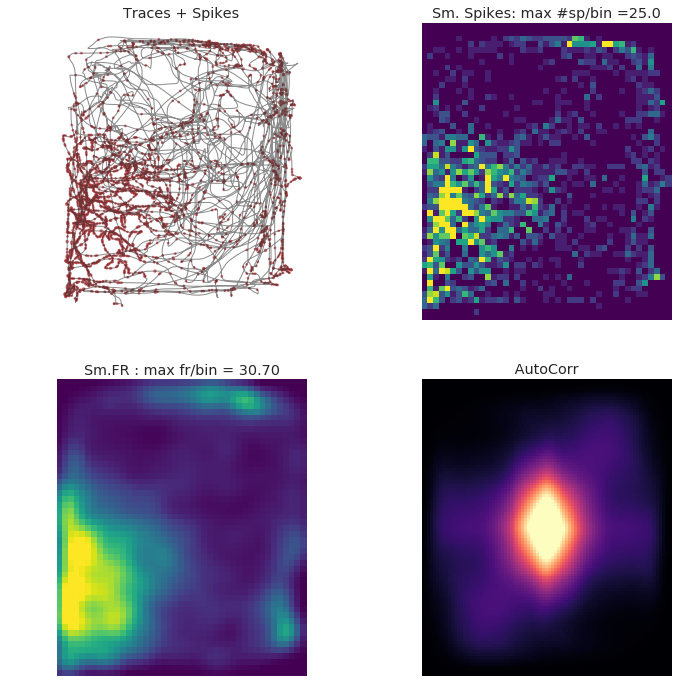

In [1392]:
spikes = cell_bin_spikes[3]
PosFRStats = getPosFR(spikes, OFBehavDat)
plotXYSpikes(OFBehavDat['x'],OFBehavDat['y'],spikes,PosFRStats['PosSpikes'],PosFRStats['smPosFR'],PosFRStats['AutoCorr'])


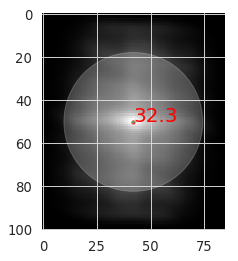

(-0.9319722760912772, False)

In [1235]:
calculate_gridscore(PosFRStats['AutoCorr'],1)

### comparison of autocorrelation function

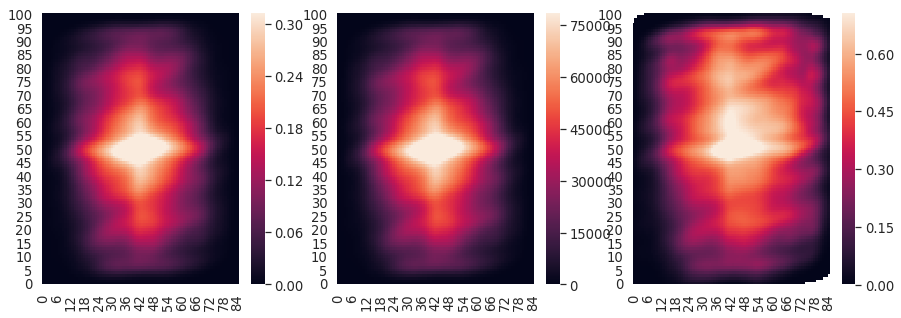

In [1236]:
X = PosFRStats['smPosFR']

f,ax=plt.subplots(1,3,figsize=(15,5))
ax[0] = sns.heatmap(acc2d(X),robust=True,ax=ax[0])
ax[0].invert_yaxis()

ax[1] = sns.heatmap(signal.correlate2d(X,X),robust=True,ax=ax[1])
ax[1].invert_yaxis()

ax[2] = sns.heatmap(normxcorr2(X,X),robust=True,ax=ax[2])
ax[2].invert_yaxis()

### Head direction functions

In [1342]:
ST = reload(ST)
OF = reload(OF)

spikes = cell_bin_spikes[1]

HD = OFBehavDat['HD']
HD_Stats = OFBehavDat['HD_Stats']

sp = OFBehavDat['sp']
sp_mask = sp>OFBehavParams['spThr']

bins = HD_Stats['bins']
binCenters = HD_Stats['binCenters']
angTime = HD_Stats['counts']*OFBehavParams['timeStep']

HD_FRStats = getAngleFR(np.deg2rad(HD[sp_mask]), spikes[sp_mask], angTime, bins)

Speed_Stats = getSpeedStats(sp,spikes)
PosFRStats = getPosFR(spikes, OFBehavDat)

In [1373]:
def getAngleFR(th,spikes,angTime,bins):
    angSp,_ = np.histogram(th,bins=bins,weights=spikes)
    angFR = angSp/angTime
    
    step = bins[1]-bins[0]
    binCenters = bins[:-1]+step
    
    z = np.mean(angFR*np.exp(1j*binCenters))
    ang = np.angle(z)
    r = np.abs(z)
    p,R = rayleigh(binCenters,angFR)
    
    angFRStats = {'angFR':angFR, 'angSp':angSp ,'bins': bins,'binCenters':binCenters,'ang':ang, 'r':r, 'R':R, 'pval':p}
    
    return angFRStats

def getSpeedStats(speed,spikes,step =0.02):
    sp_bins = np.arange(0,56,3)
    sp_binCounts,_ =np.histogram(sp,bins=sp_bins)
    sp_spikes,_ = np.histogram(sp,bins=sp_bins,weights=spikes)
    sp_time = sp_binCounts*step
    sp_FR = sp_spikes/sp_time
    
    r=np.corrcoef(sp_bins[:-1],sp_FR)[0,1]
    
    Speed_Stats = {'bins':sp_bins,'speedBinCounts':sp_binCounts,'spikeBinCounts':sp_spikes,'sp_FR':sp_FR,'r':r}
    return Speed_Stats

def getPosFR(spikes, OFBehavDat, secThr =0.05, spThr = 5, xLims = [-650,650], yLims = [-100,1450]):
    
    # get behavioral variables
    Occ_SmSecs = OFBehavDat['Occ_SmSecs']
    x =  OFBehavDat['x']
    y =  OFBehavDat['y']
    sp = OFBehavDat['sp']
    
    # get speed and occupancy masks
    sp_mask = sp>spThr
    Occ_mask = Occ_SmSecs>secThr

    OccTime = np.full_like(Occ_SmSecs,0)
    OccTime[Occ_mask] = Occ_SmSecs[Occ_mask]

    # compute position spikes
    PosSpikes,_,_ = getSpikesPos(y[sp_mask],x[sp_mask], spikes[sp_mask], yLims,xLims)
    smPosFR =  getSmFR(PosSpikes,OccTime,)
    
    # get autocorrelation
    autoCorr = acc2d(smPosFR)
    
    # get spatial information
    si = spatial_information(OccTime,smPosFR)
    si_p, si_z = getSI_ShuffleScore(x[sp_mask],y[sp_mask],spikes[sp_mask],OccTime,si)
    
    PosFRStats = {'PosSpikes':PosSpikes, 'smPosFR':smPosFR, 'OccTime': OccTime, 'AutoCorr': autoCorr, 'SI': [si,si_z,si_p]}

    return PosFRStats

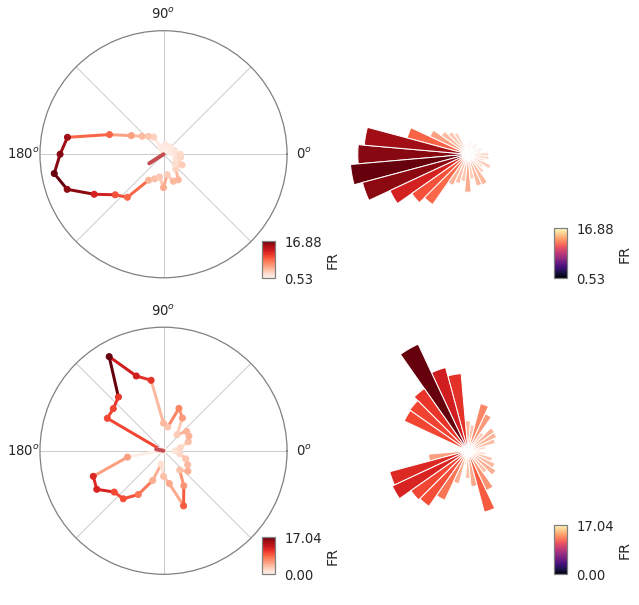

In [1343]:
f=plt.figure(figsize=(10,10))

cnt=1
for i in [1,2]:
    if i==1:
        th = HD_FRStats['angFR']
        r = HD_FRStats['r']
        ang = HD_FRStats['ang']
    else:
        th = HA_FRStats['angFR']
        r = HA_FRStats['r']
        ang = HA_FRStats['ang']
    #colors = plt.cm.magma(th/th.max())
    colors = plt.cm.Reds(th/th.max())

    ax = f.add_subplot(2,2,cnt,projection='polar')

    #ax.plot(bins,np.append(th,th[0]),color='k',linewidth=2,zorder=1)
    ax.scatter(bins[:-1],th,color=colors,zorder=2)
    colorline(bins,np.append(th,th[0]),colors=np.append(colors,[colors[0]],axis=0),ax=ax)
    ax.plot([0,ang],[0,r],color='r',linewidth=4,solid_capstyle='round')
    #ax.scatter([0,ang],[0,r],color='r',linewidth=4,solid_capstyle='round')
    #ax.scatter(ang,r,s=50,color='red')
    ax.set_xticklabels(['$0^o$','','$90^o$','','$180^o$'])
    ax.set_yticks([])
    cax=getColBar(ax,th,cmap='Reds',cax_pos=[0.9,0,0.05,0.15])
    cax.set_ylabel('FR')
    
    cnt+=1
    
    ax = f.add_subplot(2,2,cnt,projection='polar')
    
    ax.bar(bins[:-1],th,width=OF.OFBehavParams['ang2bin'],color=colors,bottom=th.min())
    cax=getColBar(ax,th)
    cax.set_ylabel('FR')
    ax.set_axis_off()
    cnt+=1




In [1374]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, z=None, colors=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0,ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    if colors is None:
        lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    else:
        lc = mcoll.LineCollection(segments, colors=colors,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def getColBar(ax,values,cmap = 'magma',cax_pos=[0.85,0,0.05,0.2]):
    

    pos = ax.get_position()
    cax = plt.axes([pos.x0+pos.width*cax_pos[0],pos.y0+cax_pos[1],pos.width*cax_pos[2],pos.height*cax_pos[3]])
    
    cMap=mpl.colors.ListedColormap(sns.color_palette(cmap,50))
    vmax = values.max()
    vmin = values.min()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cMap)

    mapper.set_array([])
    cbar = plt.colorbar(mapper,ticks=[vmin,vmax],cax=cax)
    cax.yaxis.set_tick_params(right=False)
    return cax

In [1346]:
Speed_Stats

{'bins': array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
        51, 54]),
 'speedBinCounts': array([3805, 2874, 2719, 2399, 2266, 2042, 1888, 1637, 1488, 1410, 1187,
        1080,  978,  916,  842,  773,  639,  497]),
 'spikeBinCounts': array([254., 197., 183., 195., 202., 177., 171., 149., 130., 137., 128.,
        123., 112., 105., 157., 151., 116.,  84.]),
 'sp_FR': array([3.33771353, 3.42727905, 3.3652078 , 4.06419341, 4.45719329,
        4.33398629, 4.52860169, 4.55100794, 4.36827957, 4.85815603,
        5.39174389, 5.69444444, 5.72597137, 5.73144105, 9.32304038,
        9.76714101, 9.07668232, 8.45070423]),
 'r': 0.8935684148966873}

In [1527]:
def plotOFSpikeFits(OFBehavDat,spikes,PosFRStats,HD_FRStats,Speed_Stats):
    
    def plotSpeedFR(sp_bins,sp_fr,ax):
        ax.plot(sp_bins,sp_fr,linewidth=4)
        ax.set_xlabel(' Speed [cm/s]')
        ax.set_ylabel(' FR [sp/s]')
        ax.set_ylim([np.min(sp_fr)*0.9,np.max(sp_fr)*1.1])
        ax.set_xlim([-1,52])
        ax.set_title('Speed Tunning')
        return ax
    
    def plotHDFR(ang_bins,ang_fr,ang,r,ax):
        colors = plt.cm.Reds(ang_fr/ang_fr.max())
        
        ax.scatter(ang_bins[:-1],ang_fr,color=colors,zorder=2)
        colorline(ang_bins,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0),ax=ax)
        
        ax.plot([0,ang],[0,r],color='k',linewidth=4,solid_capstyle='round')
        #ax.set_xticklabels(['$0^o$','','','','$180^o$'])
        ax.set_xticklabels(['E','','','','W'])
        ax.set_yticks([])
        cax=getColBar(ax,ang_fr,cmap='Reds',cax_pos=[0.9,0,0.05,0.15])
        cax.set_ylabel('FR')
        ax.set_ylim([0,np.max(ang_fr)*1.1])
        
        ax.set_title('HD Tunning')
        return ax
    
    def plotXYtraces(x,y,spikes,ax):
        ax.plot(x,y,linewidth=1,color='k',alpha=0.5)
        ax.scatter(x,y,s=spikes*3,color='r',alpha=0.7)
        ax.set_aspect('equal',adjustable='box')
        ax.set_axis_off()
        ax.set_title('Traces + Spikes')
        return ax
    
    def plotSmOFR(smFRPos,ax):
        vmax=smFRPos.max()
        ax = sns.heatmap(smFRPos,xticklabels=[],yticklabels=[],cmap='viridis',robust=True,square=True,cbar=False,ax=ax)
        ax.invert_yaxis()
        ax.set_title('Sm.FR : max fr/bin = {0:0.2f}'.format(vmax) )
        return ax
    
    wTop,hTop=0.35,0.35
    wBot,hBot=0.28,0.28
    pos = [[0.1,0.55,wTop,hTop],[0.55,0.55,wTop,hTop],[0.1,0.2,wBot,hBot],[0.62,0.2,wBot,hBot]]
    f = plt.figure(figsize=(10,10))
    ax = []
    
    for a in np.arange(1,5):
        if a==3:
            ax.append(f.add_subplot(2,2,a,projection='polar'))
        else:
            ax.append(f.add_subplot(2,2,a))
    for i,a in enumerate(ax):
        a.set_position(pos[i])
    
    x,y = OFBehavDat['x'],OFBehavDat['y']
    ax[0] = plotXYtraces(x,y,spikes,ax[0])
    
    ax[1] = plotSmOFR(PosFRStats['smPosFR'],ax[1])
     
    bins,angFR =  HD_FRStats['bins'], HD_FRStats['angFR']
    r,ang = HD_FRStats['r'],HD_FRStats['ang'] 
    ax[2] = plotHDFR(bins,angFR,ang,r,ax[2])
    
    speed_bins = Speed_Stats['bins'][:-1]
    speed_FR = Speed_Stats['sp_FR']
    ax[3] = plotSpeedFR(speed_bins,speed_FR,ax[3])
    
    return f,ax

Go through multiple cells

In [1685]:
an = 'Ne'
task = 'OF'
fn = oakPaths['Root'] / (an+'_SessionPaths.pkl')
with fn.open(mode="rb") as f:
    sePaths = pkl.load(f)

CT_Path =  oakPaths['Clustered'] / an / (an+'_ClusteringSummary.json')
with CT_Path.open() as f:
    CT = json.load(f)
    
sePaths.keys()

dict_keys(['Ne_OF_052318', 'Ne_OF_052418', 'Ne_OF_052518', 'Ne_OF_052818', 'Ne_OF_052918', 'Ne_OF_053018', 'Ne_OF_053118', 'Ne_OF_060118', 'Ne_OF_060418', 'Ne_OF_060518', 'Ne_OF_060718', 'Ne_OF_060818', 'Ne_OF_061118', 'Ne_OF_061218', 'Ne_OF_061318', 'Ne_OF_061418', 'Ne_OF_061518', 'Ne_OF_061818', 'Ne_OF_062018', 'Ne_OF_062518', 'Ne_OF_062618', 'Ne_OF_062718', 'Ne_OF_062818', 'Ne_OF_071118', 'Ne_OF_080118', 'Ne_OF_080218', 'Ne_T3g_052318', 'Ne_T3g_052418', 'Ne_T3g_052518', 'Ne_T3g_052818', 'Ne_T3g_052918', 'Ne_T3g_053018', 'Ne_T3g_053118', 'Ne_T3g_060118', 'Ne_T3g_060418', 'Ne_T3g_061218', 'Ne_T3g_061318', 'Ne_T3g_061418', 'Ne_T3g_061518', 'Ne_T3g_061818', 'Ne_T3g_062018', 'Ne_T3g_062518', 'Ne_T3g_062618', 'Ne_T3g_062918', 'Ne_T3g_070518', 'Ne_T3g_070618', 'Ne_T3g_070918', 'Ne_T3g_071018', 'Ne_T3g_071118', 'Ne_T3g_072518', 'Ne_T3g_072618', 'Ne_T3g_073018', 'Ne_T3g_080118', 'Ne_T3g_080318', 'Ne_T3i_060518', 'Ne_T3i_060618', 'Ne_T3i_060818', 'Ne_T3i_061118', 'Ne_T3i_062918', 'Ne_T3i_0702

In [1687]:
for ss,tt in CT[an].items():
    for t,dat in tt.items(): 
        if t=='OF':
            print(ss)
            print(dat['nCells'],dat['nMua'])

051618
0 0
051718
0 0
051818
0 0
052118
0 0
052218
0 0
052318
0 0
052418
0 0
052518
0 0
052818
0 8
052918
2 8
053018
0 0
053118
0 0
060118
0 0
060418
0 0
060518
2 3
060718
1 7
060818
0 0
061118
6 6
061218
5 12
061418
0 2
061518
0 0
061818
7 8
062018
1 5
062518
5 4
062618
1 0
062718
0 2
062818
0 0
071118
7 6
080118
2 3
080218
3 4


In [1698]:
se = 'Ne_OF_071118'

OFBehavDat = OF.getOFBehavior(sePaths[se])
cell_bin_spikes, mua_bin_spikes, ids= SF.getSessionBinSpikes(sePaths[se],resamp_t=OFBehavDat['t'])


Binned Spikes Files not Found or overwrite=1, creating them.
Loaded Spike Files.
Bin Spike File Creation and Saving Completed.


In [1699]:
nCells,nMua=len(cell_bin_spikes),len(mua_bin_spikes)
print(nCells,nMua)

7 6


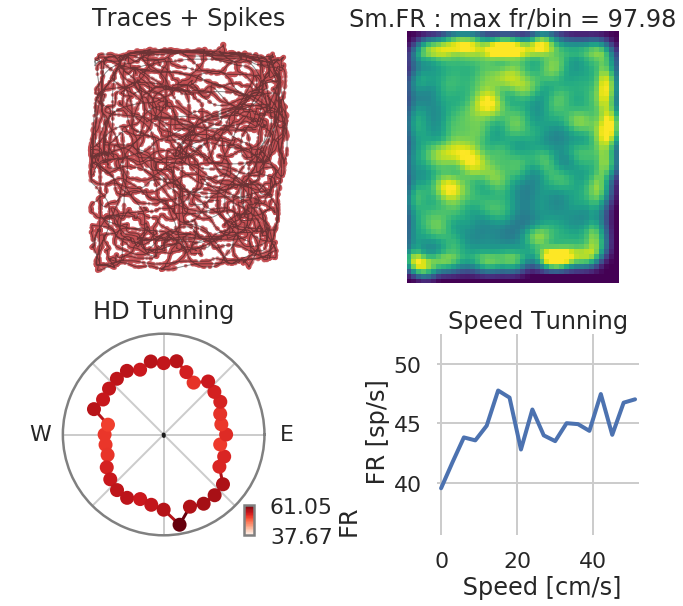

In [1706]:
### unitID = 11 se = 'Li_OF_060518'
# unitID = 2, se= 'Li_OF_061118'
unitID = 6
spikes = cell_bin_spikes[unitID]
#spikes = mua_bin_spikes[unitID]

HD = OFBehavDat['HD']
HD_Stats = OFBehavDat['HD_Stats']

sp = OFBehavDat['sp']
sp_mask = sp>OFBehavParams['spThr']

bins = HD_Stats['bins']
binCenters = HD_Stats['binCenters']
angTime = HD_Stats['counts']*OFBehavParams['timeStep']

HD_FRStats = getAngleFR(np.deg2rad(HD[sp_mask]), spikes[sp_mask], angTime, bins)

Speed_Stats = getSpeedStats(sp,spikes)
PosFRStats = getPosFR(spikes, OFBehavDat)

f,ax=plotOFSpikeFits(OFBehavDat,spikes,PosFRStats,HD_FRStats,Speed_Stats)

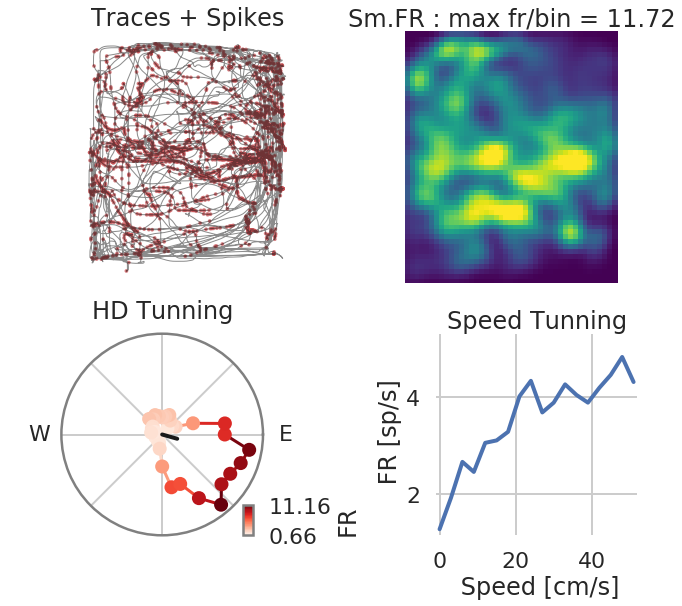

In [1665]:
#sns.set_context('poster')
#plotSP = Path('/mnt/c/Users/alexg8/Documents/SfN2019/Plots/')

f,ax=plotOFSpikeFits(OFBehavDat,spikes,PosFRStats,HD_FRStats,Speed_Stats)
f.savefig(plotSP / 'OF_SpikesTun2.png',dpi=300, bbox_inches='tight', pad_inches=0.2)

In [1448]:
p = ax[0].get_position()
p.x0,p.y0,p.width,p.height

(0.11970873029512205, 0.55, 0.3105825394097559, 0.35)

(0.30451747172068505, 0.34318181818181814)